In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
from scipy.stats import chisqprob
import pylab as pb

In [2]:
def build_XI(input_list):
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,I

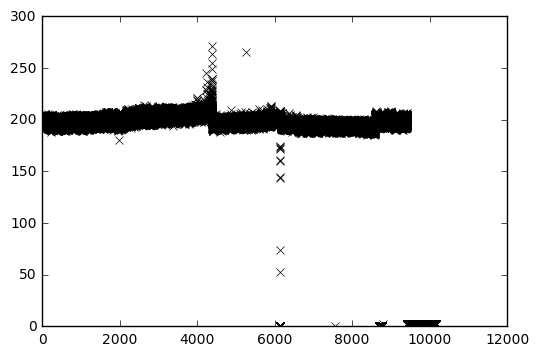

In [3]:
# mat_file1 = io.loadmat('2014_Dataset1.mat')
# t = mat_file1['t']
# p1 = mat_file1['p1']
# p2 = mat_file1['p2']
# x = np.arange(0,len(p2)/10,0.1)[:,None]
# plt.plot(x,p2,'kx')
# plt.show()
# for i in range(len(x)-1):
#     if p2[i]<190:
#         print (i)

mat_file2 = pd.read_csv('dataset 1781.csv')
p1 = np.array(mat_file2['P1'])[:,None]
p2 = np.array(mat_file2['P2'])[:,None]
x = np.arange(0,len(p2)/10,0.1)[:,None]
# for i in range(len(p2)):
#     if p2[i]<5:
#         p2[i] = p2[i]*100
plt.plot(x[0:101682],p2[0:101682],'kx')
plt.show()

In [4]:
import pickle
f = open('d:/hyperparameter3','rb')
gp = pickle.load(f)
f.close()

In [5]:
f2 = open('d:/hyperparameter3_latter','rb')
gp2 = pickle.load(f2)
f2.close()

In [8]:
Month = []
for i in range(len(mat_file2)):
    if mat_file2['Day'][i] == 1 and mat_file2['Hour'][i] == 0 and mat_file2['Minute'][i]==0:
        Month.append(i)
Mon = list(Month)[0:10]+[86897]+[92773]+[Month[11]]
mat_file2.loc[Mon,:]

,HISTID,Year,Month,Day,Hour,Minute,P1,P2
0,1781,2014,1,1,0,0,2.930,197.376
8928,1781,2014,2,1,0,0,2.930,198.657
16992,1781,2014,3,1,0,0,2.926,199.939
25914,1781,2014,4,1,0,0,2.923,202.868
34551,1781,2014,5,1,0,0,2.936,204.516
43472,1781,2014,6,1,0,0,2.936,212.389
52108,1781,2014,7,1,0,0,2.936,201.038
61036,1781,2014,8,1,0,0,2.930,201.038
69964,1781,2014,9,1,0,0,2.945,197.925
78343,1781,2014,10,1,0,0,2.945,192.066


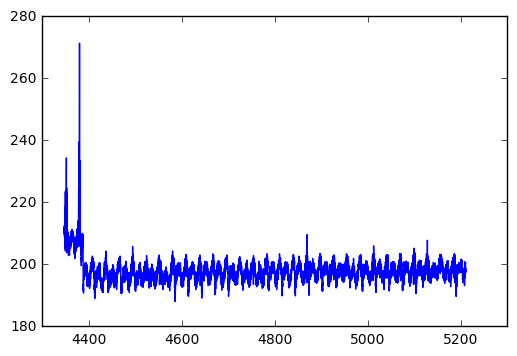

In [13]:
plt.plot(x[Mon[5]:Mon[6]],p2[Mon[5]:Mon[6]])
plt.show()

In [9]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    
    plt.xlabel('X',fontsize=16)
    plt.ylabel('Y',fontsize=16)
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)
    ax1.legend(loc=3)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)
    ax2.legend(loc=3)

Initial threshold : {'up': 5.4529666666664127, 'down': -6.8155583333334846}
Number of peaks : {'up': 37, 'down': 37}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ                0.00                0.00
	                   σ                0.50                0.61
	          likelihood               11.34               18.92
	    Extreme quantile                5.44               -6.81
	------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████| 99682/99682 [00:01<00:00, 83194.78it/s]


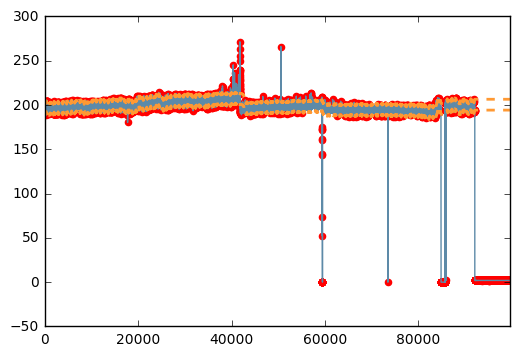

In [12]:
from spot import bidSPOT
q = 0.02 				# risk parameter
d = 120  				# depth parameter
s = bidSPOT(q,d) 

X = p2[0:101682]
X = np.reshape(X,(1,len(X))).flatten()
n_init = 2000
init_data = X[:n_init] 	# initial batch
data = X[n_init:] 
s.fit(init_data,data) 	# data import
s.initialize() 	  		# initialization step
results = s.run()    	# run
s.plot(results)

# plt.xlim([6820,6970])
# plt.ylim([190,260])
plt.show()

In [14]:
a = results['alarms']
al = np.array(a) +2000
spot_m = np.zeros(12)
for i in range(len(al)):
    for j in range(len(Mon)-1):
        if Mon[j] <= al[i] <= Mon[j+1]:
            spot_m[j] += 1
        else:
            pass    
spot_m

array([  372.,   485.,   649.,   571.,   414.,   910.,   137.,   169.,
         118.,   349.,  1394.,  7622.])

# EVT-GP


In [10]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = (2*np.log(n))**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n))+np.log(2*np.pi))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.98))
    return zp

def Mahalanobis_distance(model,x_test,y2):
    X,I = build_XI([x_test,x_test])
    mean, variance = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(y2-mean[l:2*l]),np.linalg.inv(variance[l:2*l,l:2*l])),y2-mean[l:2*l])

    return MD2

kern = gp.kern.copy()
kern2 = gp2.kern.copy()

In [17]:
s = Mon[7]
l = 120

it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
test_points = []
test_points2 = []
chi_sq = []
con_bd = []
step = 1

for i in range(Mon[8]-Mon[7]-l):
    # 기존 100개 model에 z 구하기
    new = it[len(it)-1]+step
    test_points.append(new)
    
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern2)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    print(new)
    # pointwise detection
   
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,I = build_XI([x[jt],x[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp

    if i == 0:
        for j in range(len(con_ue)):
            con_bd.append([con_ue[j],con_le[j]])
            test_points2.append([jt[j],jt[j]])
    else:
        con_bd.append([con_ue[len(con_ue)-1],con_le[len(con_le)-1]])
        test_points2.append([new,new])
  
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt.pop(0)
        kt = kt + list([new])
        step = 1
        
    # trajectory detection    
    
    mul2 = GPy.models.GPCoregionalizedRegression([x[kt],x[it[0:len(it)-12]]],[p1[kt],p2[it[0:len(it)-12]]],kernel = kern2)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    ct = it[len(it)-12:len(it)]
    md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
    cs = chisqprob(md2,len(ct))[0][0]
    chi_sq.append(cs)
#     if cs <0.02:
#         plot_2outputs(mul2, xlim=(x[kt[0]],x[kt[len(kt)-1]]),x_1=x[kt],x_2=x[it[0:len(it)-12]])
#         plt.plot(x[ct],p2[ct],'kx')
#         plt.show()

61156
61157
61158
61159
61160
61161
61162
61163
61164
61165
61166
61167
61168
61169
61170
61171
61172
61173
61174
61175
61176
61177
61178
61179
61180
61181
61182
61183
61184
61185
61186
61187
61188
61189
61190
61191
61192
61193
61194
61195
61196
61197
61198
61199
61200
61201
61202
61203
61204
61205
61206
61207
61208
61209
61210
61211
61212
61213
61214
61215
61216
61217
61218
61219
61220
61221
61222
61223
61224
61225
61226
61227
61228
61229
61230
61231
61232
61233
61234
61235
61236
61237
61238
61239
61240
61241
61242
61243
61244
61245
61246
61247
61248
61249
61250
61251
61252
61253
61254
61255
61256
61257
61258
61259
61260
61261
61262
61263
61264
61265
61266
61267
61268
61269
61270
61271
61272
61273
61274
61275
61276
61277
61278
61279
61280
61281
61282
61283
61284
61285
61286
61287
61288
61289
61290
61291
61292
61293
61294
61295
61296
61297
61298
61299
61300
61301
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
6132

In [16]:
trend = []

for i in range(len(chi_sq)):
    if chi_sq[i] < 0.02:
        trend.append(test_points[i])
        
day = []
t_count = 0
for i in range(len(trend)-1):
    if i == 0:
        t_count += 1
    else:
        if trend[i]-trend[i-1]<6:
            pass
        else:
            if trend[i+1]-trend[i] <6:
                t_count += 1

print(len(anomal_points),t_count)

946 63


In [17]:
from collections import Counter

a = Counter(day)
df = pd.DataFrame.from_dict(a, orient='index').reset_index()
df = df.rename(columns={'index':'day', 0:'count'})

df.to_csv('point.csv',index=False)

b = Counter(day_p)
df2 = pd.DataFrame.from_dict(b, orient='index').reset_index()
df2 = df.rename(columns={'index':'day', 0:'count'})
df2.to_csv('trend.csv',index=False)
# Counter(day_p)

NameError: name 'day_p' is not defined

In [75]:
Counter(day_p)

Counter({1: 4,
         2: 1,
         4: 1,
         7: 7,
         8: 1,
         9: 2,
         11: 1,
         13: 1,
         14: 3,
         15: 1,
         16: 2,
         20: 1,
         22: 1,
         23: 2,
         25: 1,
         31: 9,
         33: 1,
         34: 2,
         42: 3,
         43: 1,
         44: 1,
         45: 1,
         47: 1,
         48: 2,
         50: 3,
         53: 1,
         59: 12})

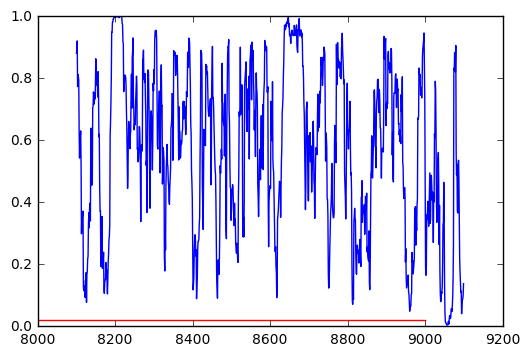

In [17]:
plt.plot(test_points[8000:9000],chi_sq[8000:9000])
a = np.linspace(8000,9000,1000)
th = 0.02*np.ones(a.shape)
plt.plot(a,th,color='red')
plt.show()

In [12]:
f = (np.array(test_points2)[:,0]/10)[:,None][:,0]
c1 = (np.array(con_bd)[:,0])[:,0]
c2 = (np.array(con_bd)[:,1])[:,0]

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


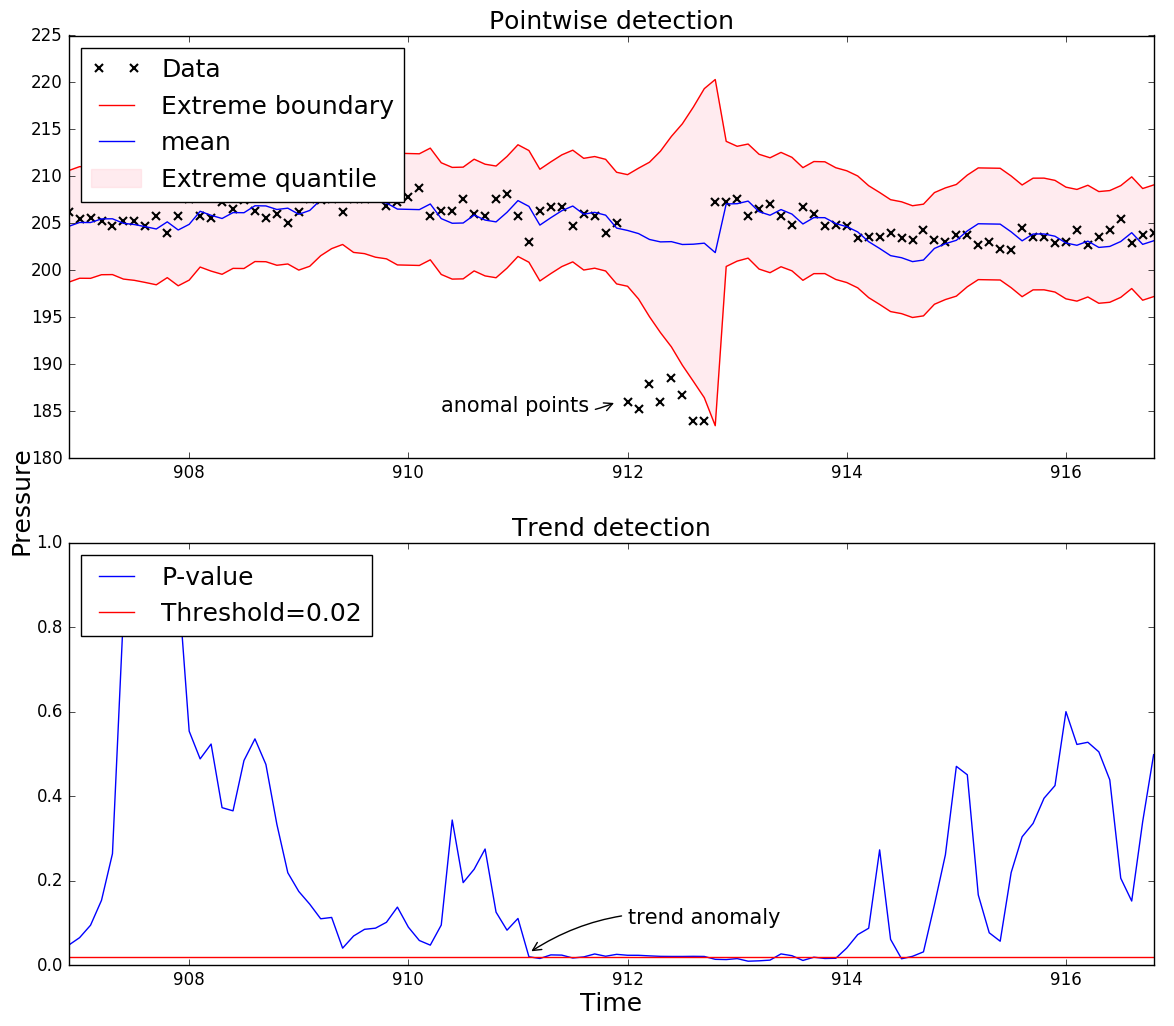

In [21]:
fig = pb.figure(figsize=(14,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
    
plt.xlabel('Time',fontsize=18)
plt.ylabel('Pressure',fontsize=18)
#Output 1
ax1 = fig.add_subplot(211)
ax1.set_xlim([906.9,916.8])
ax1.set_title('Pointwise detection',fontsize=18)
ax1.tick_params(labelsize=12)
ax1.plot(x[test_points],p2[test_points],'kx',mew = 1.5,label="Data")
ax1.plot(np.array(test_points2)[:,0]/10,np.array(con_bd)[:,0],color='red',label="Extreme boundary")
ax1.plot(np.array(test_points2)[:,1]/10,np.array(con_bd)[:,1],color='red')
ax1.fill_between(f, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")
ax1.plot(np.array(test_points2)[:,1]/10,(c1+c2)/2,color='blue',label="mean")
ax1.legend(loc=2,fontsize=18)
ax1.annotate('anomal points', xy=(911.9, 186), xytext=(910.3, 185), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

#Output 2
ax2 = fig.add_subplot(212)
ax2.set_xlim([906.9,916.8])
ax2.set_ylim([0,1])
ax2.set_title('Trend detection',fontsize=18)
ax2.tick_params(labelsize=12)
ax2.legend(loc=3)
ax2.plot(x[test_points],chi_sq,label="P-value")
a = np.linspace(906.9,916.8,100)
th = 0.02*np.ones(a.shape)
ax2.plot(a,th,color='red',label="Threshold=0.02")
ax2.legend(loc=2,fontsize=18)
ax2.annotate('trend anomaly', xy=(911.1, 0.03), xytext=(912, 0.1), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
fig.savefig('1.png')
plt.show()